# Speaker theory derivation using SymPy

Francis Deck

**Goal**: Derive the speaker response equations from the definitions of the Thiele-Small parameters and basic electromechanical laws. I'm using Wikipedia for my reference on the TS parameters:

https://en.wikipedia.org/wiki/Thiele/Small_parameters

All of my calculations will be done using **sympy**, the symbolic algebra package for Python. As a result, I've hopefully minimized my chance of making mistakes in long drawn-out derivations.

A drawback of **sympy** and most other computer algebra tools, is that they don't necessarily preserve the ordering of symbols, thus it's hard to enforce good notational conventions. The expressions will be harder to read than ones entered by hand.

In [2]:
import matplotlib.pyplot as plt
import sympy as sp
import numpy as np
from IPython.display import display, Math

def displayEq(sym, expr):
    display(Math(sym + ' = ' + sp.latex(expr)))

**Sympy** needs to have all symbols defined. I'm putting them all in one place, to keep them from cluttering the rest of the notebook.

In [3]:
V, x, v, a, X = sp.symbols('V x v a X')
V_in, omega, t = sp.symbols('V_in omega t', real=True)
I = sp.symbols('I')
R_e, Z_e, L_e, Bl = sp.symbols('R_e Z_e L_e Bl', real=True, positive=True)
Q_es, Q_ms, w_s, rho, c, S_d, V_as = sp.symbols('Q_es Q_ms w_s rho c S_d, V_as', real=True, positive=True)
F_mag = sp.symbols('F_mag')
F_spring = sp.symbols('F_spring')
F_damp = sp.symbols('F_damp')
F_inertial = sp.symbols('F_inertial')
M_ms = sp.symbols('M_ms', real=True, positive=True)
R_ms = sp.symbols('R_ms', real=True, positive=True)
C_ms = sp.symbols('C_ms', real=True, positive=True)
gamma, P_atm = sp.symbols('gamma P_atm', real=True)
F_box = sp.symbols('F_box')
r = sp.symbols('r', real=True, positive=True)
V_box, f_port, S_port, w_p = sp.symbols('V_box f_port S_port w_port', real=True, positive=True)
X_port, m_port, F_cone = sp.symbols('X_port m_port F_cone', real=True)

# Basic equation of motion for the driver

## Definition of terms, phasor transformation

The phasor transformation is a mathematical tool that allows us to convert a time-domain signal into a frequency-domain signal. It's based on a strong limiting assumption of linear behavior, meaning that f(a + b) = f(a) + f(b). This is also called a "small signal" model.

The magnitudes V and X are assumed to be complex, meaning that they carry both magnitude and phase.

The "physical laws" used here are all approximate. Each one assigns a single parameter to a physical behavior, so that the resulting equations remain simple. Empirically, the laws work pretty well in the small-signal domain, and speakers are designed to obey those laws.

In [4]:
V_in = sp.nsimplify(V*sp.exp(1j*omega*t))
x = sp.nsimplify(X*sp.exp(1j*omega*t))
v = sp.diff(x, t)
a = sp.diff(v, t)

displayEq('V_{in}', V_in)
displayEq('x', x)
displayEq('v', v)
displayEq('a', a)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Ohm's Law and Faraday's Law

Ohm's law $V = IZ_e$

Here, $Z_e = R_e + i \omega\ L_e$, which combines the resistance and inductance of the voice coil.

Faradays Law: $V = Blv$

These are summed together, to get the total voltage on the coil. Faraday's Law is based on the empirical discovery that moving a conductor through a magnetic field induces a voltage across the conductor. This is also how a dynamic microphone works. The voltage due to voice coil motion is referred to as the "back EMF" of the speaker.

$Bl$ is the product of the magnetic field and the length of wire suspended in the field. The general form of Faraday's Law is a vector equation, but the speaker is designed so that the voice coil wire is always perpendicular to the field.

The total voltage across the terminals of the voice coil is the sum of these two terms. We enter the equation for the voltage, then solve it for the current.

In [5]:
I = sp.solve(sp.Eq(V_in, I*Z_e + Bl*v), I)[0]

displayEq('I', I)

<IPython.core.display.Math object>

## Magnetic force law

Current flowing through the coil imposes a force:

$F_{mag} = BlI$

I've substituted the equation for $I$ given above.

In [6]:
F_mag = sp.expand(Bl*I)

displayEq('F_{mag}', F_mag)

<IPython.core.display.Math object>

## Hooke's Law

The suspension of the cone (spider and surround) resist its displacement. A single parameter, the "compliance," relates force and displacement. It's the reciprocal of the familiar spring constant from physics class.

In [7]:
F_spring = -x/C_ms

displayEq('F_{spring}', F_spring)

<IPython.core.display.Math object>

## Mechanical damping

The suspension is not a perfect spring. A small amount of the energy required to move the coil is converted into heat by friction in the materials. This is represented by a velocity-dependent force with a single damping constant.

Note that the velocity is represented by the derivative of displacement.

In [8]:
F_damp = -R_ms*v

displayEq('F_{damp}', F_damp)

<IPython.core.display.Math object>

## Inertial force

Newton's Law is the familiar $F = ma$ from physics class. I'm representing it as a force that resists acceleration.

In [9]:
F_inertial = -1*M_ms*a

displayEq('F_{inertial}', F_inertial)

<IPython.core.display.Math object>

## Combined equation of motion

This equation is Newton's third law, which is that the sum of the forces on the cone is zero. It expresses everything we know about the speaker so far.

In [10]:
eq1 = sp.Eq(0, F_mag + F_spring + F_damp + F_inertial)

eq1

Eq(0, -I*Bl**2*X*omega*exp(I*omega*t)/Z_e + Bl*V*exp(I*omega*t)/Z_e + M_ms*X*omega**2*exp(I*omega*t) - I*R_ms*X*omega*exp(I*omega*t) - X*exp(I*omega*t)/C_ms)

## Solving the equation of motion

In [11]:
x_driver = sp.solve(eq1, X)[0]

displayEq('X', x_driver)

<IPython.core.display.Math object>

## The impedance curve

Impedance is the ratio of voltage to current, both of which have already been expressed as equations.

In [12]:
z_driver = sp.simplify((V_in/I).subs(X, x_driver))

displayEq('Z', z_driver)

# Does it correctly get the DC resistance?

z_driver.subs(omega, 0)

<IPython.core.display.Math object>

Z_e

## Unpack the Thiele-Small parameters

Datasheets usually give the Thiele-Small parameters but not always the electromechanical parameters. I'm going to treat the definitions of the Thiele-Small parameters as 4 equations and solve for the elctromechanical parameters. The result is a set of formulas for computing the EM parameters.

I've elaborated on the constants $c^2 \rho$ in the section about the sealed box.

In [13]:
eq2 = sp.Eq(w_s, 1/sp.sqrt(C_ms*M_ms))
eq3 = sp.Eq(Q_es, R_e/Bl**2*sp.sqrt(M_ms/C_ms))
eq4 = sp.Eq(Q_ms, sp.sqrt(M_ms/C_ms)/R_ms)
eq5 = sp.Eq(V_as, rho*c**2*S_d**2*C_ms)

params = sp.solve((eq2, eq3, eq4, eq5), (C_ms, M_ms, R_ms, Bl))[0]
display(eq2)
display(eq3)
display(eq4)
display(eq5)
display('Formulas for computing EM parameters from TS parameters')
displayEq('C_{ms}', params[0])
displayEq('M_{ms}', params[1])
displayEq('R_{ms}', params[2])
displayEq('B_{l}', params[3])

Eq(w_s, 1/(sqrt(C_ms)*sqrt(M_ms)))

Eq(Q_es, sqrt(M_ms)*R_e/(Bl**2*sqrt(C_ms)))

Eq(Q_ms, sqrt(M_ms)/(sqrt(C_ms)*R_ms))

Eq(V_as, C_ms*S_d**2*c**2*rho)

'Formulas for computing EM parameters from TS parameters'

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Choosing a driver and box for examples

I've chosen the Eminence DeltaLite 2512-ii driver because I have one in a cabinet that I'm happy with. The data are from here:

https://eminence.com/products/deltalite_ii_2512#specifications

While some of the EM parameters are given, I'm going to compute them from the TS parameters anyway, to check that my calculations work.

I've included all of the parameters from the datasheet. The ones that are commented out are not used yet, or are computed by my code.

In anticipation of getting to the box and port theories, I've added parameters for a basic ported box.

In [14]:
driver_params = {
    # Thiele-Small parameters from Eminence DeltaLite 2512-ii driver
    'Znom': 8, # Nominal impedance, Ohms
    #'P_e': 250, # Rated power, Watts
    'f_s': 53.1, # Resonant frequency, Hz
    w_s: sp.N(53.1*2*sp.pi), # Resonant angular frequency, Hz
    R_e: 5.28, # DC resistance, Ohms
    L_e: 0.31*1e-3, # Voice coil inductance, H
    Q_ms: 2.94, # Mechanical Q factor
    Q_es: 0.64, # Electrical Q factor
    V_as: 67.44*1e-3, # Compliance equivalent air volume, m^3
    #'C_ms': 0.18*1e-3, # Mechanical compliance, m/N
    #'Bl': 11.6, # Motor strength, Tesla*m
    #'M_ms': 48.58*1e-3, # Mechanical mass, kg
    'X_max': 4.9*1e-3, # Maximum linear excursion, m
    S_d: 519.5*1e-4, # Diaphragm area, m^2
    # Additional physical constants
    rho: 1.2, # Air density, kg/m^3
    c: 343, # Speed of sound, m/s
    'P_in_rms': 100, # Input power, Watts
}
# Convert Watts to amplitude in Volts
driver_params[V] = sp.sqrt(driver_params['P_in_rms']*driver_params['Znom'])*sp.sqrt(2)
# Combine resistance and inductance
driver_params[Z_e] = driver_params[R_e] + 1j*omega*driver_params[L_e]
# Frequency to angular frequency
driver_params[w_s] = sp.N(driver_params['f_s']*2*sp.pi)
driver_params['Q_ts'] = 1/(1/driver_params[Q_es] + 1/driver_params[Q_ms])

box_params = {
    V_box: 32*1e-3, # Box volume, liters converted to m^3
    f_port: 40,
    S_port: 21*3.5*1e-4, # Port area, cm*cm converted to m^2
}

box_params[w_p] = 2*sp.pi*box_params[f_port]

This code creates a set of electromechanical parameters for the driver and box.

In [15]:
em_params = driver_params | {sym: p.subs(driver_params) 
                             for sym, p in zip([C_ms, M_ms, R_ms, Bl], params)}

em_params |= box_params

em_params

{'Znom': 8,
 'f_s': 53.1,
 w_s: 333.637139811236,
 R_e: 5.28,
 L_e: 0.00031,
 Q_ms: 2.94,
 Q_es: 0.64,
 V_as: 0.06744,
 'X_max': 0.004900000000000001,
 S_d: 0.05195,
 rho: 1.2,
 c: 343,
 'P_in_rms': 100,
 V: 40,
 Z_e: 0.00031*I*omega + 5.28,
 'Q_ts': 0.525586592178771,
 C_ms: 0.000177001510143870,
 M_ms: 0.0507544644346362,
 R_ms: 5.75971916551807,
 Bl: 11.8195595670753,
 V_box: 0.032,
 f_port: 40,
 S_port: 0.007350000000000001,
 w_port: 80*pi}

## Generate an excursion curve for the bare driver

The **subs()** method lets you substitute an entire list of parameters into an expression *en masse*. This actually results in *less code* than my earlier programs.

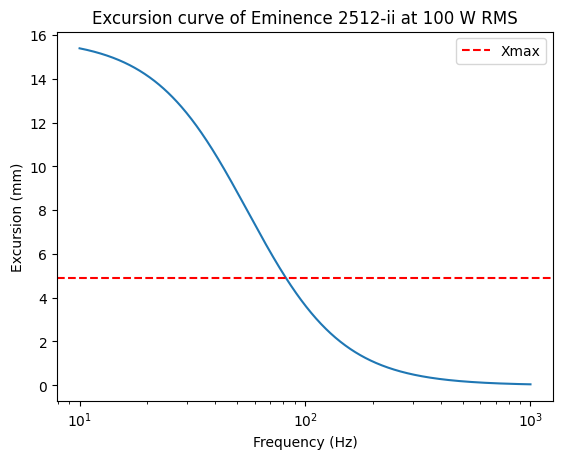

In [16]:
fa = np.logspace(1, 3, 1000)
wa = 2*np.pi*fa

def excursion_curve(em_params, verbose = False):
    '''
    First, substitute the EM parameters into the excursion function. This
    results in an expression that's purely a function of omega. It's ugly,
    but not meant to be readable.
    '''
    xfunc_sp = x_driver.subs(em_params)
    if verbose:
        display(xfunc_sp)
    '''
    Next, convert into a numpy function, for speedy computation. If you've
    got a decent computer, you'll notice that doing all of this math symbolically
    is barely slowing down the computation at all.
    '''
    xfunc_np = sp.lambdify(omega, xfunc_sp, 'numpy')
    '''
    Finally, plot it.
    '''
    plt.semilogx(fa, np.abs(xfunc_np(wa))*1000)
    plt.gca().axhline(em_params['X_max']*1000, color='r', linestyle='--', label = 'Xmax')
    plt.title('Excursion curve of Eminence 2512-ii at ' + str(em_params['P_in_rms']) + ' W RMS')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Excursion (mm)')
    plt.legend()
    
excursion_curve(em_params)

## Generate an impedance curve for the bare driver

Same basic schtick.

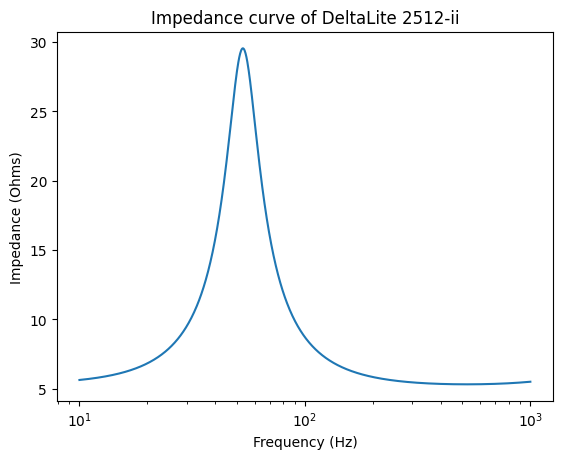

In [17]:
def impedance_curve(em_params):
    zfunc_sp = z_driver.subs(em_params)
    zfunc_np = sp.lambdify(omega, zfunc_sp, 'numpy')
    zabs = np.abs(zfunc_np(wa))
    plt.semilogx(fa, zabs)
    plt.title('Impedance curve of DeltaLite 2512-ii')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Impedance (Ohms)')

impedance_curve(em_params)

## The sealed box

Excursion of the cone changes the volume inside the box, and thus its pressure. In turn, pressure imparts a force on the cone. This restoring force, proportional to displacement, works exactly like the restoring force of the suspension. First, the change of volume...

In [18]:
dV = (S_d)*X
displayEq('dV', dV)

<IPython.core.display.Math object>

... resulting in a change of pressure. Some details are given here. I've borrowed the equation for adiabatic compression, and expressed it in this way:

$P = P_{atm}(\dfrac {V}{V_{box}})^{\gamma}$

where $P_atm$ is the atmospheric pressure and $\gamma$ is a thermodynamic constant equal to roughly 1.4 for air. And making an approximation:

$\Delta P = \Delta V \dfrac {dP}{dV}$

Thus, $\Delta P = \Delta V \dfrac {P_{atm} \gamma}{V_{box}}$

However, the constants $\gamma P_{atm}$ can be replaced by $\rho c^2$ where $\rho$ is the density of air and $c$ is the speed of sound in air. I'm using $\rho c^2$ because they were already introduced in the section on the Thiele-Small parameters.

https://en.wikipedia.org/wiki/Adiabatic_process

https://en.wikipedia.org/wiki/Speed_of_sound

In [19]:
dP = (gamma*P_atm*dV/V_box).subs(gamma*P_atm, c**2*rho)
displayEq('dP', dP)

<IPython.core.display.Math object>

... resulting in a force.

In [20]:
F_box = dP*S_d
displayEq('F_{box}', F_box)

<IPython.core.display.Math object>

What have we got here? A force that's proportional to displacement, just like a spring. Thus we can express the effect of the box as a *compliance* which is the reciprocal of the spring constant from physics class.

In [21]:
C_box = X/F_box

displayEq('C_{box}', C_box)

<IPython.core.display.Math object>

Now we can model the effect of the box. I've just combined the compliances of the driver and the box in parallel. You can see the benefit of the box. Below the resonant frequency, excursion remains roughly constant, which protects the driver from damage due to exceeding its mechanical limit. When we look at the SPL curve, we'll see that we've paid a price in low frequency extension, and gained a small but manageable "hump" in the curve.

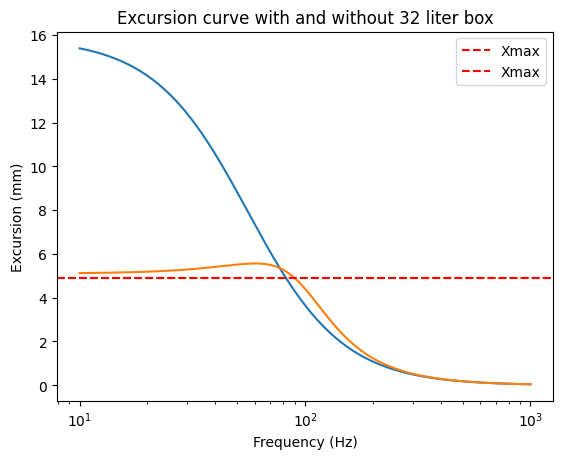

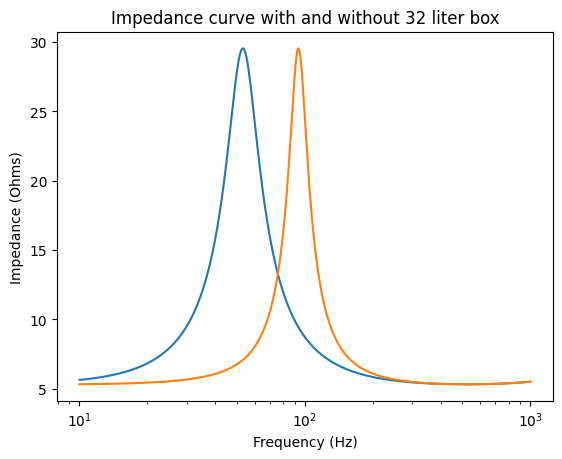

In [22]:
em_box_params = dict(em_params)
em_box_params[C_ms] = 1/(1/em_params[C_ms] + 1/(C_box.subs(driver_params)))
excursion_curve(em_params)
excursion_curve(em_box_params)
plt.title('Excursion curve with and without 32 liter box')
plt.show()
impedance_curve(em_params)
impedance_curve(em_box_params)
plt.title('Impedance curve with and without 32 liter box')
plt.show()

## Acoustical output

I've found this reference, from a set of acoustics lecture notes. The author derives the "far field" response of a perfect piston radiator in an infinite baffle.

https://jontallen.ece.illinois.edu/uploads/473.F18/Lectures/Chapter_7b.pdf

The equation on p. 23 is:

$p(r, \Theta, t) = \dfrac {j \omega \rho_0 a^2 U_o}{2r}$

$e^{j(\omega t - kr)}$

$\dfrac {2 J_1(ka \sin \Theta)}{ka \sin \Theta}$

I'm only interested in the amplitude of $p$,

$P(r) = \dfrac {j \omega \rho a^2 U_o}{2r}$

$U_o$ = Linear velocity of the radiator

$a$ = Radius of cone

$r$ = Distance to listening position

Converting to our symbol convention, we're left with:

$P = \dfrac {\omega^2 \rho S_d X}{2 \pi r}$


In [23]:
em_params[r] = 1
em_box_params[r] = 1

P = omega**2*rho*S_d/2/sp.pi/r*x_driver
displayEq('P', P)

<IPython.core.display.Math object>

Text(0, 0.5, 'Sensitivity (dB SPL) @ 100 W @ 1m')

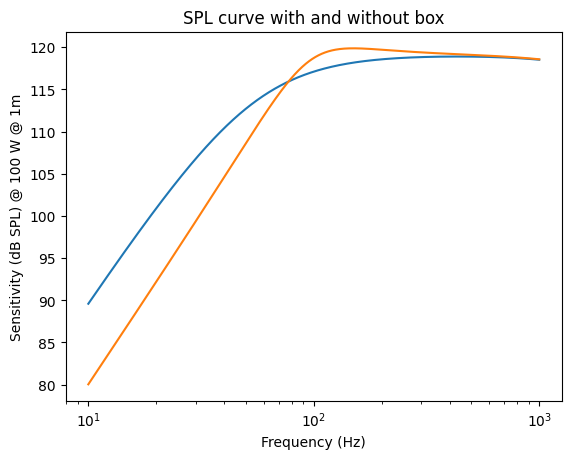

In [24]:
def sensitivity_curve(em_params):
    pfunc_sp = P.subs(em_params)
    pfunc_np = sp.lambdify(omega, pfunc_sp, 'numpy')
    pabs = np.abs(pfunc_np(wa))
    pabs_db = 20*np.log10(pabs/20e-6)
    plt.semilogx(fa, pabs_db)

sensitivity_curve(em_params)
sensitivity_curve(em_box_params)
plt.title('SPL curve with and without box')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Sensitivity (dB SPL) @ ' + str(em_params['P_in_rms']) + ' W @ 1m')

## How the port works

Introducing the symbols:

$S_d$ = Frontal area of cone

$S_p$ = Frontal area of port

$x$ = Displacement of the cone.

$x_p$ = Displacement of the "slug" of air inside the port

$m_{ms}$ = Mass of cone

$m_p$ = Mass of air inside the port

The port air mass is modeled as a piston, just as the cone is. The total change of volume is equal to the sum of the volumes displaced by the cone and the port:

In [25]:
dV = S_port*X_port + S_d*X

displayEq('dV', dV)

<IPython.core.display.Math object>

Change in pressure within the box. My previous derivation by hand used $\gamma P_{atm}$, so I'll make the substitution here.

In [26]:
dP = sp.expand(-gamma*P_atm*dV/V_box).subs(gamma*P_atm, c**2*rho)

displayEq('dP', dP)

<IPython.core.display.Math object>

Equation for the force on the cone from the pressure in the box

In [27]:
eq1 = sp.Eq(F_cone, sp.expand(dP*S_d))

eq1

Eq(F_cone, -S_d**2*X*c**2*rho/V_box - S_d*S_port*X_port*c**2*rho/V_box)

I'm going to anticipate the progress of this derivation, based on having done it by hand in the past. I'll define $m_p$ in terms of the port resonant frequency. This is mainly aesthetic, to make the equations look more symmetrical. But also, the resonant frequency is typically what you plug into a speaker design program.

In [28]:
m_port = (gamma*P_atm*S_port**2/V_box/w_p**2).subs(gamma*P_atm, c**2*rho)

displayEq('m_{port}', m_port)

<IPython.core.display.Math object>

Equation for the force on the port, including the inertial force on the port mass, where the mass will be defined as above.

In [29]:
eq2 = sp.Eq(0, sp.expand(omega**2*X_port*m_port + dP*S_port))

eq2

Eq(0, -S_d*S_port*X*c**2*rho/V_box + S_port**2*X_port*c**2*omega**2*rho/(V_box*w_port**2) - S_port**2*X_port*c**2*rho/V_box)

These are two equations in two variables, can be solved for the cone and port motion

In [30]:
result = sp.solve([eq1, eq2], [X, X_port])

displayEq('X', result[X])
displayEq('X_{port}', result[X_port])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Displacement divided by force is a compliance. This compliance can be added in parallel to the cone compliance.

In [31]:
C_ported = sp.simplify(-result[X]/F_cone)

displayEq('C_{ported}', C_ported)

<IPython.core.display.Math object>

Isolate the relationship between the cone and port excursions

In [32]:
frac = sp.simplify(result[X_port]/result[X])

displayEq('X_{port}/X', frac)

<IPython.core.display.Math object>

Defining a symbol 

$\kappa = \dfrac {\omega^2}{\omega^2 - \omega_p^2}$, 

compute the total displacement volume 

$S_d x + S_{port} x_{port}$, 

which produces the outgoing acoustic wavefront.

Now we get to see if the simulation still works. First, we need to fill in the new parameters added to the model: The port tuning frequency and box volume.

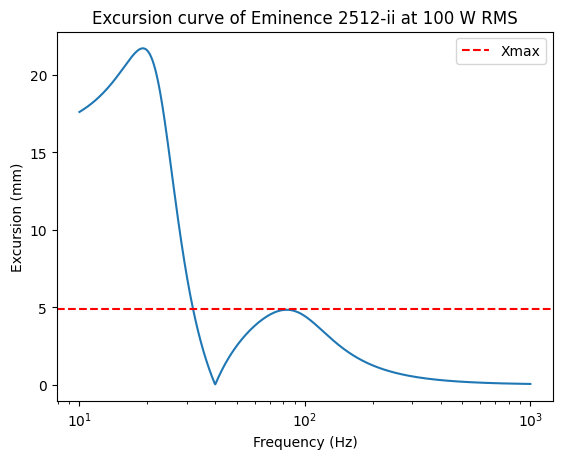

In [33]:
em_params[w_p] = sp.N(40*2*sp.pi)
em_params[V_box] = 32*1e-3
em_ported_params = dict(em_params)
em_ported_params[C_ms] = 1/(1/em_params[C_ms] + 1/C_ported.subs(em_params))
excursion_curve(em_ported_params)


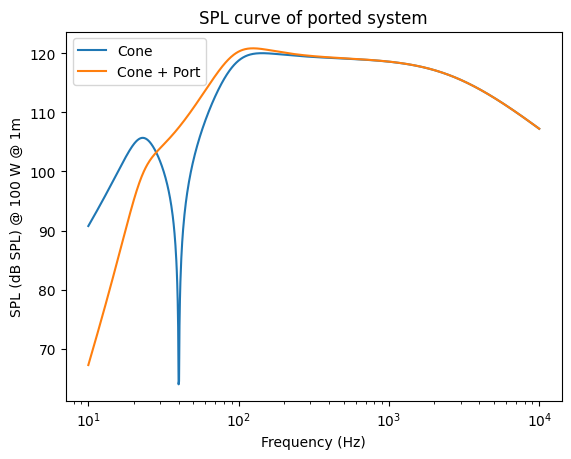

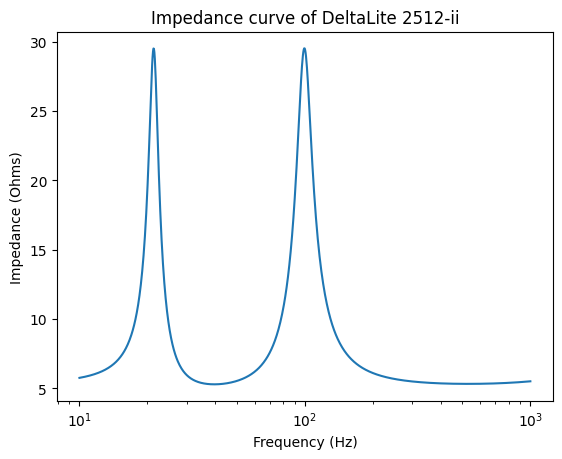

In [34]:
def sensitivity_curve_ported(em_params, verbose = False):
    fa = np.logspace(1, 4, 1000)
    wa = 2*np.pi*fa
    P_driver = omega**2*rho*S_d/2/sp.pi/r*x_driver
    pfunc_sp = P_driver.subs(em_params)
    pfunc_np = sp.lambdify(omega, pfunc_sp, 'numpy')
    pabs = np.abs(pfunc_np(wa))
    pabs_db = 20*np.log10(pabs/20e-6)
    plt.semilogx(fa, pabs_db, label = 'Cone')

    kappa = (omega**2/(omega**2 - w_p**2))
    P_total = (omega**2*rho*S_d/2/sp.pi/r*x_driver*kappa).subs(em_params)
    if verbose:
        display(P_total)
    ptotalfunc_sp = sp.lambdify(omega, P_total, 'numpy')
    ptotalabs = np.abs(ptotalfunc_sp(wa))
    ptotalabs_db = 20*np.log10(ptotalabs/20e-6)
    plt.semilogx(fa, ptotalabs_db, label = 'Cone + Port')
    plt.legend()

sensitivity_curve_ported(em_ported_params)
plt.title('SPL curve of ported system')
plt.xlabel('Frequency (Hz)')
plt.ylabel('SPL (dB SPL) @ ' + str(em_params['P_in_rms']) + ' W @ 1m')
plt.show()
impedance_curve(em_ported_params)

## Port air speed

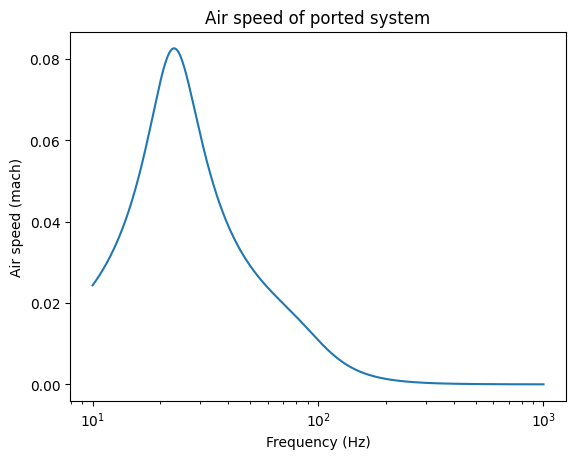

In [35]:
def airspeed_curve_ported(em_params, verbose = False):
    kappa = (omega**2/(omega**2 - w_p**2))
    vfunc_sp = (1j*omega*x_driver*frac/c).subs(em_params)
    if verbose:
        displayEq('v_{func}', vfunc_sp)
    vfunc_np = sp.lambdify(omega, vfunc_sp, 'numpy')
    vabs = np.abs(vfunc_np(wa))
    plt.semilogx(fa, vabs)
    plt.title('Air speed of ported system')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Air speed (mach)')

airspeed_curve_ported(em_ported_params)

## Port length, crudely

There are more detailed port length calculators, that take the "end effects" of the port into account. I'm going to leave those for now, and look strictly at the air mass inside the port, which has this volume:

In [36]:
V_port = m_port/rho
V_port

S_port**2*c**2/(V_box*w_port**2)

Thus the length is the volume divided by the area...

In [37]:
L_port = V_port/S_port
L_port

S_port*c**2/(V_box*w_port**2)

... and we can hang some numbers on it, in meters of course:

In [38]:
L_port.subs(em_ported_params)

0.427805024987206

In [1]:
!quarto render "speakerTheorySympy.ipynb" --to pdf

pandoc 
  to: latex
  output-file: speakerTheorySympy.tex
  standalone: true
  pdf-engine: xelatex
  variables:
    graphics: true
    tables: true
  default-image-extension: pdf
  
metadata
  documentclass: scrartcl
  classoption:
    - DIV=11
    - numbers=noendperiod
  papersize: letter
  header-includes:
    - \KOMAoption{captions}{tableheading}
  block-headings: true
  title: Speaker theory derivation using SymPy
  

Rendering PDF
running xelatex - 1
  This is XeTeX, Version 3.141592653-2.6-0.999996 (TeX Live 2024) (preloaded format=xelatex)
   restricted \write18 enabled.
  entering extended mode
  
running xelatex - 2
  This is XeTeX, Version 3.141592653-2.6-0.999996 (TeX Live 2024) (preloaded format=xelatex)
   restricted \write18 enabled.
  entering extended mode
  

Output created: speakerTheorySympy.pdf

